# Introdução

Olá, meu nome é Marcio Constâncio Junior. Sou professor de física de Ensino Médio mas estou estudando tópicos de Ciência de Dados para realizar uma transição de carreira para esta área. Este notebook faz parte do projeto _lighthouse_ da _Indicium_. Para saber mais sobre o programa, clique <a href=https://indicium.solides.jobs/vacancies/212928#vacancyDescription> aqui</a>. 

A seguir, apresento o desafio proposto para a área de Ciência de Dados, junto com o dicionário dos dados. Por fim, segue minha Análise Exploratória dos dados, de onde tento tirar alguns _insights_ sobre os dados e sobre os tipos de falhas. Espero que gostem!

## Desafio

Seu objetivo é identificar quais máquinas apresentam potencial de falha tendo como base dados extraídos através de sensores durante o processo de manufatura.  Para isso são fornecidos dois datasets: um dataset chamado desafio_manutencao_preditiva_treino composto por 6667 linhas, 9 colunas de informação (features) e a variável a ser prevista (“failure_type”). 

O segundo dataset chamado de desafio_manutencao_preditiva_teste possui 3333 linhas e 8 colunas e não possui a coluna “failure_type”. Seu objetivo é prever essa coluna a partir dos dados enviados e nos enviar para avaliação dos resultados.

Você poderá encontrar em anexo um dicionário dos dados.

## Dicionário dos dados

O conjunto de dados consiste de 10.000 datos armazenados na forma de linhas com 8 características indicadas nas colunas:

1. `UID`: identificador único entre 1 e 10000.
2. `product ID`: Id do produto. Consiste das letras L, M ou H para _low_ (50% of all products), _medium_ (30%) e _high_ (20%) como variantes da qualidade do produto, acrescida de um número serial.
3. `type`: Tipo do produto, indicado pelas letras L, M ou H, conforme indicado na coluna `product ID`.
4. `air temperature [K]`: gerado usando uma processo de coleta aleatória e depois nrmalizado para um desvio padrão de 2 K em torno de 300 K.
5. `process temperature [K]`: gerado usando uma processo de coleta aleatória e depois nrmalizado para um desvio padrão de 1 K, adicionado à temperatura do ar mais 10 K.
6. `rotational speed [rpm]`: calculado a partir de uma potência de 2860 W, sobreposta com um ruído normalmente distribuído.
7. `torque [Nm]`: os valores de torque são normalmente distribuídos em torno de 40 N.m com desvio padrão de 10 N.m e sem valores negativos.
8. `tool wear [min]`: As variantes de qualidade H/M/L adicionam 5/3/2 minutos de desgaste da ferramenta à ferramenta utilizada no processo.

O rótulo `failure_type` indica se a máquina (descrita naquela linha) falhou num determinado ponto. A falha das máquinas consiste de cinco modos de falhas independentes:

1. tool wear failure (TWF): a ferramenta será substituída por falha em um tempo de desgaste da ferramenta selecionado aleatoriamente entre 200 - 240 minutos (120 vezes em nosso conjunto de dados). Neste momento, a ferramenta é substituída 69 vezes e falha 51 vezes (atribuídas aleatoriamente).

2. heat dissipation failure (HDF): a dissipação de calor causa uma falha do processo, se a diferença entre a temperatura do ar e do processo for inferior a 8,6 K e a velocidade de rotação da ferramenta for inferior a 1380 rpm. Este é o caso de 115 pontos de dados.

3. power failure (PWF): o produto do torque e da velocidade de rotação (em rad/s) é igual à potência necessária para o processo. Se esta potência estiver abaixo de 3500 W ou acima de 9000 W, o processo falha, o que ocorre 95 vezes em nosso conjunto de dados.

4. overstrain failure (OSF): se o produto do desgaste da ferramenta e do torque exceder 11.000 minNm para a variante de produto L (12.000 M, 13.000 H), o processo falha devido à sobrecarga. Isso é verdade para 98 pontos de dados.

5. random failures (RNF): cada processo tem uma chance de 0,1% de falhar independentemente de seus parâmetros de processo. Este é o caso de apenas 5 pontos de dados, menos do que o esperado para 10.000 pontos de dados em nosso conjunto de dados.

Se pelo menos um dos modos de falha acima for verdadeiro, o processo falha e o rótulo 'falha da máquina' é definido como 1. Portanto, não é transparente para o método de aprendizado de máquina qual dos modos de falha causou a falha do processo.

In [1]:
#Importando as principais bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print(f'Versão do numpy usada neste projeto: {np.__version__}')
print(f'Versão do pandas usada neste projeto: {pd.__version__}')
print(f'Versão do seaborn usada neste projeto: {sns.__version__}')
!pip show matplotlib

Versão do numpy usada neste projeto: 1.22.3
Versão do pandas usada neste projeto: 1.4.2
Versão do seaborn usada neste projeto: 0.11.2
Name: matplotlib
Version: 3.5.2
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /home/marcio/anaconda3/envs/MarcioDS/lib/python3.10/site-packages
Requires: python-dateutil, numpy, pyparsing, kiwisolver, packaging, fonttools, pillow, cycler
Required-by: seaborn


In [3]:
#Carregando o conjunto de dados
df = pd.read_csv('desafio_manutencao_preditiva_treino.csv')
df.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure


A seguir, faremos a primeira descrição do dataset, usando o comando `df.info()`. Nele, teremos a informação do nome, tipo e quantidade de não-nulos de cada coluna.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    6667 non-null   int64  
 1   product_id             6667 non-null   object 
 2   type                   6667 non-null   object 
 3   air_temperature_k      6667 non-null   float64
 4   process_temperature_k  6667 non-null   float64
 5   rotational_speed_rpm   6667 non-null   int64  
 6   torque_nm              6667 non-null   float64
 7   tool_wear_min          6667 non-null   int64  
 8   failure_type           6667 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 468.9+ KB


Vemos que das nove colunas, seis são numéricas (sendo três do tipo _float64_ e 3 do tipo _int64_) enquanto as outras três são do tipo object. Dessas três variáveis object, uma é o ID do produto, que será excluida do dataset por tratar-se de uma identificação de cada produto. Outra variável que também pode ser deletada é a `uid`, que é um identificador numérico das peças, único e com valores entre 1 e 10000.

De acordo com o dicionário dos dados, existem cinco classes de falha, vamos fazer uma contagem na variável `failure_type` para saber como estão distribuídas estas falhas. 

In [5]:
#Valores de falhas já convertido em porcentagem
round(df['failure_type'].value_counts(normalize=True),3)*100

No Failure                  96.5
Heat Dissipation Failure     1.1
Power Failure                0.9
Overstrain Failure           0.8
Tool Wear Failure            0.4
Random Failures              0.2
Name: failure_type, dtype: float64

Como sabíamos, trata-se de um problema de multi-classes, com grande desbalanço entre a classe `No failure` e as outras. 

Antes de tudo, vamos deletar as colunas que não usaremos (`udi` e `product_id`) para, em seguida, começar nossa análise exploratória das variáveis numéricas com o comando `df.describe()`.

In [6]:
df = df.drop(columns=['udi','product_id'])

In [7]:
df.describe()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
count,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000
mean,299.992515,309.992620,1537.419529,40.058512,108.098095
std,1.994710,1.488101,177.182908,9.950804,63.359915
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1422.500000,33.200000,54.000000
50%,300.000000,310.000000,1503.000000,40.200000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,251.000000


Vemos dos dados acima que as temperaturas possuem possuem um desvio padrão dentro do esperado, uma vez que, segundo a descrição dos dados, o desvio padrão para a variável `air_temperature_k` é de 2 K ao redor de 300 K. A variável `process_temperature_k` aparenta ter um desvio padrão um pouco mais elevado, dado que segundo a descrição, deveria ter o erro normalizado para  1 K, com acréscimo de 10 K em relação à temperatura do ar. Olhando a distância interquartil (IQR) dá pra perceber que não existem _outliers_ dentre estes dados. Para confirmar, vamos fazer um boxplot das temperaturas. 

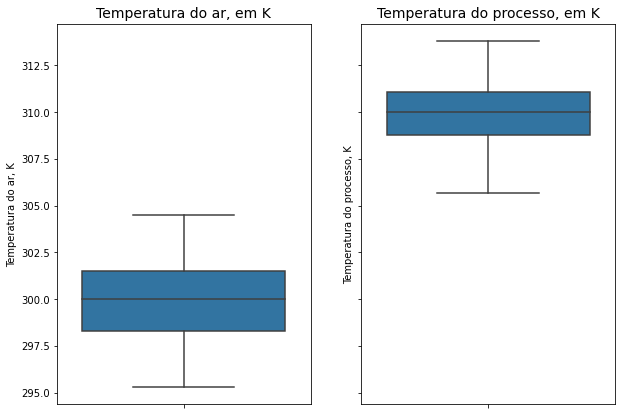

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7), sharey=True)
plt.title('Temperaturas')
sns.boxplot(y = 'air_temperature_k',data=df,ax=axes[0])
axes[0].set(ylabel = 'Temperatura do ar, K')
axes[0].set_title('Temperatura do ar, em K',fontsize=14)
sns.boxplot(y = 'process_temperature_k',data=df,ax=axes[1])
axes[1].set_title('Temperatura do processo, em K',fontsize=14)
plt.ylabel('Temperatura do processo, K')
plt.show()

Ainda nas temperaturas, vamos fazer um _scatterplot_ para ver como estão distribuídos as temperaturas de cada equipamento. Para ajudar na visualização, vamos separá-las de acordo com o tipo de falha. 

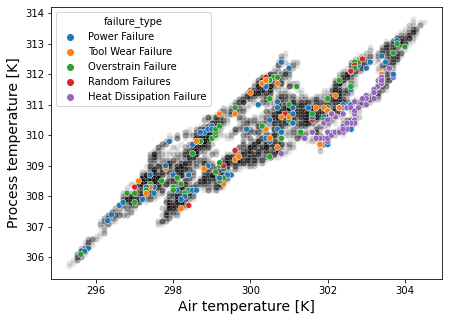

In [9]:
#df_sample = df.sample(frac=0.5)
fig = plt.figure(figsize=(7, 5))
sns.scatterplot(x = 'air_temperature_k', y = 'process_temperature_k',data=df[df['failure_type']=='No Failure'],alpha=0.1,color = 'black')
sns.scatterplot(x = 'air_temperature_k', y = 'process_temperature_k',data=df[df['failure_type']!='No Failure'],hue='failure_type',alpha=1)
plt.ylabel('Process temperature [K]',fontsize=14)
plt.xlabel('Air temperature [K]', fontsize=14)
plt.show()

É possível perceber do gráfico acima que as falhas por dissipação de calor `Heat Dissipation failure` encontram-se agrupadas. Logo, vemos que a informação sobre este tipo de falha estará correlacionada às temperaturas oferecidas. 

Antes de continuar a análise de outras características, vamos adicionar uma característica extra que relaciona a diferença entre as duas temperaturas. O dicionário de variáveis dá a entender que a diferença de temperatura do processo e do ar tem uma diferença de aproximadamente 10 K. Vejamos se isso se confirma. 

In [10]:
df['diff_temperature_air_process'] = df['process_temperature_k'] - df['air_temperature_k']
print(f"A diferença de temperatura entre o ar e o processo é de: {df['diff_temperature_air_process'].mean():.3f} +- {df['diff_temperature_air_process'].std():.3f}")

A diferença de temperatura entre o ar e o processo é de: 10.000 +- 0.997


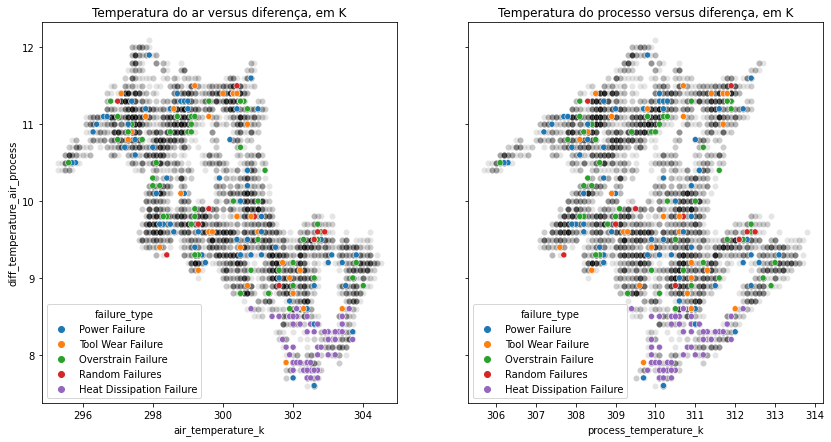

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
sns.scatterplot(x = 'air_temperature_k',
                y = 'diff_temperature_air_process',
                data=df[df['failure_type']=='No Failure'],
                ax=axes[0],
                alpha=0.1,color='black')
sns.scatterplot(x = 'air_temperature_k', y = 'diff_temperature_air_process',
                data=df[df['failure_type']!='No Failure'],
                hue = "failure_type",
                ax=axes[0])
axes[0].set_title('Temperatura do ar versus diferença, em K')
sns.scatterplot(x = 'process_temperature_k',
               y = 'diff_temperature_air_process',
                data=df[df['failure_type']=='No Failure'],
                ax=axes[1],
                alpha=0.1,color='black')
sns.scatterplot(x = 'process_temperature_k', y = 'diff_temperature_air_process',
                data=df[df['failure_type']!='No Failure'],
                hue = "failure_type",
                ax=axes[1])
axes[1].set_title('Temperatura do processo versus diferença, em K')
#plt.title('Temperaturas')
plt.show()

In [12]:

print(f"Valor máximo de diferença de temperatura na qual houve Heat Dissipation Failure: {df['diff_temperature_air_process'][df['failure_type'] =='Heat Dissipation Failure'].max():.2f} K")

Valor máximo de diferença de temperatura na qual houve Heat Dissipation Failure: 8.60 K


Fica evidente do gráfico e do cálculo apresentado acima que as falhas devido à dissipação térmica ocorrem com valores de temperatura abaixo do 10K especificados na descrição da variável. Mais especificamente, quando esta diferença de temperatura é inferior a 8.6 K, conforme descrito no dicionário dos dados, na seção sobre `Heat Dissipation Failure`.

A seguir, vamor avaliar as outras colunas do modelo para verificar as outras relações mencionadas na descrição dos dados.

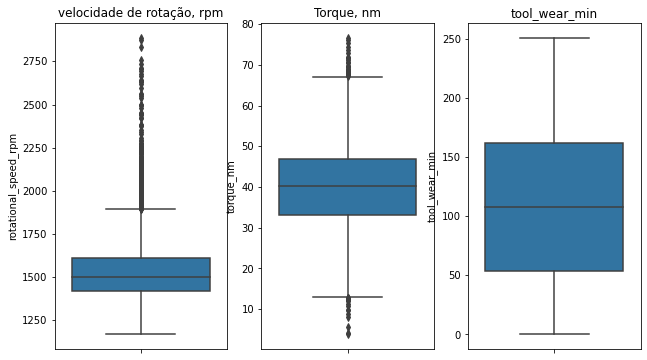

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(10.5, 6))
sns.boxplot(y = 'rotational_speed_rpm',data=df,ax=axes[0])
axes[0].set_title('velocidade de rotação, rpm')
sns.boxplot(y = 'torque_nm',data=df,ax=axes[1])
axes[1].set_title('Torque, nm')
sns.boxplot(y = 'tool_wear_min',data=df,ax=axes[2])
axes[2].set_title('tool_wear_min')
plt.show()

Vemos que, ao contrário do boxplot das temperaturas, o boxplot da velocidade de rotação e do torque apresentam _outliers_. 

Text(0.5, 1.0, 'Velocidade de rotação versus temperatura do processo')

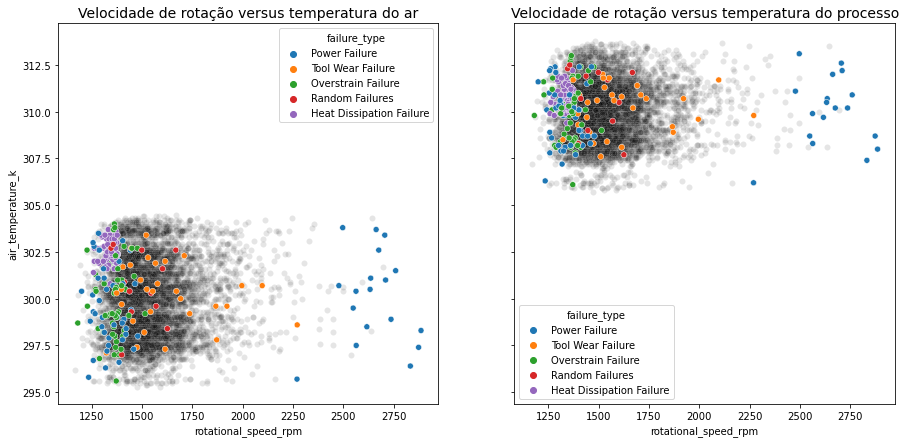

In [14]:
fig,axes = plt.subplots(1,2,figsize=(15,7),sharey=True)
sns.scatterplot(x = 'rotational_speed_rpm',
                y = 'air_temperature_k',
                data=df[df['failure_type']=='No Failure'],
                alpha=0.1,color='black',ax=axes[0])
sns.scatterplot(x = 'rotational_speed_rpm',
                y = 'air_temperature_k',
                data=df[df['failure_type']!='No Failure'],
                hue = "failure_type",ax=axes[0])
axes[0].set_title('Velocidade de rotação versus temperatura do ar',fontsize=14)

sns.scatterplot(x = 'rotational_speed_rpm',
                y = 'process_temperature_k',
                data=df[df['failure_type']=='No Failure'],
                alpha=0.1,color='black',ax=axes[1])
sns.scatterplot(x = 'rotational_speed_rpm',
                y = 'process_temperature_k',
                data=df[df['failure_type']!='No Failure'],
                hue = "failure_type",ax=axes[1])
axes[1].set_title('Velocidade de rotação versus temperatura do processo',fontsize=14)

No gráfico da velocidade de rotação versus as temperaturas (ar,processo) fica evidente que a `Power Failure` tem uma relação com a velocidade de rotação, mas não necessariamente com as temperaturas pois está distribuído ao longo do eixo das temperaturas.

No dicionário dos dados, este tipo de erro está relacionado com o produto da velocidade angular com o torque, resultando na potência necessária para que a máquina opere. Vamos avaliar esta propriedade, criando uma nova coluna do dataset, chamada `power_W`, mas antes é preciso fazer a conversão da 'velocidade' de rotação de rpm para velocidade angula, em rad/s. Para isso, dividimos por 60 e multiplicamos por 2.$\pi$. O resultado dessa conversão agora pode ser multiplicado pelo torque em N.m resultando em $\frac{N.m.rad}{s} = W$

In [15]:
df['power_W'] = round(2*np.pi*df['rotational_speed_rpm']*df['torque_nm']/60,1)
df.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,diff_temperature_air_process,power_W
0,M,298.1,308.6,1551,42.8,0,No Failure,10.5,6951.6
1,L,298.2,308.7,1408,46.3,3,No Failure,10.5,6826.7
2,L,298.2,308.7,1408,40.0,9,No Failure,10.5,5897.8
3,M,298.1,308.6,1425,41.9,11,No Failure,10.5,6252.6
4,L,298.1,308.6,1558,42.4,14,No Failure,10.5,6917.7


count     6667.000000
mean      6287.636163
std       1063.513635
min       1148.400000
25%       5569.150000
50%       6277.000000
75%       7006.000000
max      10469.900000
Name: power_W, dtype: float64


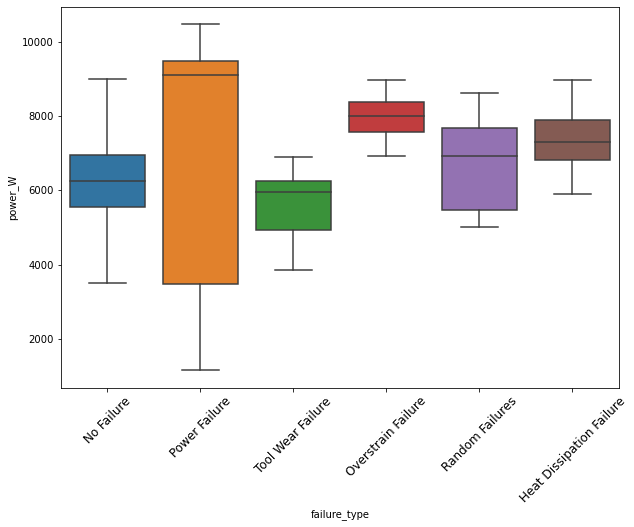

In [16]:
#Vamos ver como a coluna Power está distribuída
print(df['power_W'].describe())

plt.figure(figsize=(10,7))
sns.boxplot(y = 'power_W',x = 'failure_type', data=df)
plt.xticks(rotation=45,fontsize=12)
plt.show()

Dos dados acima vemos que a mediana dos valores de potência é de 6277 W, enquanto a mediana das peças que tiveram `Power Failure` e `Overstrain Failure` são mais altas, indicando que estes tipos de falhas podem estar mais susceptíveis à potência do equipamento. 

A seguir vamos fazer um gráfico de dispersão dos dados de `rotational_speed_rpm`, `torque_nm`, `tool_wear_min`, `power_W` e de uma outra grandeza que foi mencionada no dicionário dos dados como o produto da tool_wear e do torque. Vamos nomeá-la de `wear_x_torque`.

In [17]:
df['wear_x_torque_minNm'] = df['torque_nm']*df['tool_wear_min']
print(df['wear_x_torque_minNm'].describe())

df.head()

count     6667.000000
mean      4327.510979
std       2819.201610
min          0.000000
25%       2010.200000
50%       4010.000000
75%       6278.500000
max      16497.000000
Name: wear_x_torque_minNm, dtype: float64


,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,diff_temperature_air_process,power_W,wear_x_torque_minNm
0,M,298.1,308.6,1551,42.8,0,No Failure,10.5,6951.6,0.0
1,L,298.2,308.7,1408,46.3,3,No Failure,10.5,6826.7,138.9
2,L,298.2,308.7,1408,40.0,9,No Failure,10.5,5897.8,360.0
3,M,298.1,308.6,1425,41.9,11,No Failure,10.5,6252.6,460.9
4,L,298.1,308.6,1558,42.4,14,No Failure,10.5,6917.7,593.6


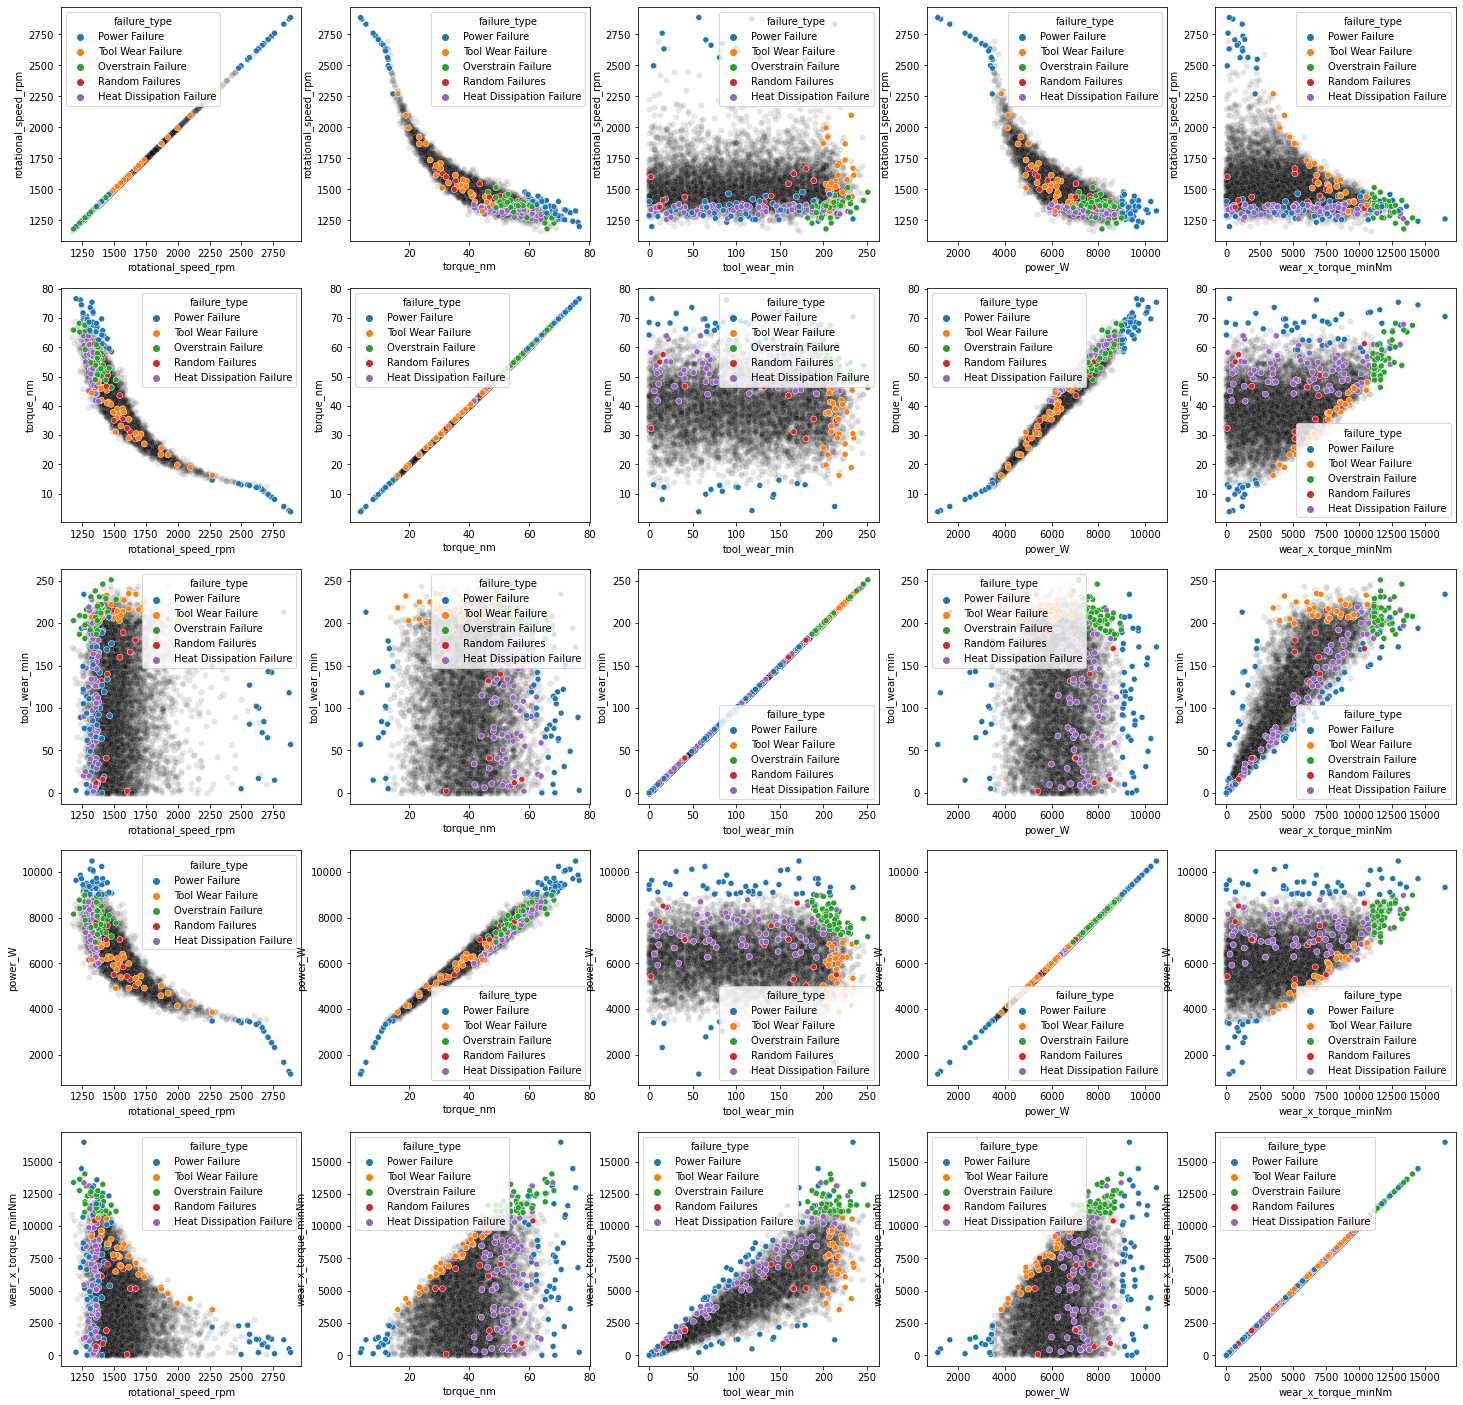

In [18]:
#fig, axes = plt.subplots(1, 3, figsize=(18, 7))

columns = ['rotational_speed_rpm','torque_nm','tool_wear_min','power_W','wear_x_torque_minNm','failure_type']

df_aux = df[columns]

fig,axes = plt.subplots(5,5,figsize=(25,25))

for column_name_1 in columns[:-1]:
    for column_name_2 in columns[:-1]:
        sns.scatterplot(x = column_name_2, y = column_name_1,
                data=df_aux[df_aux['failure_type']=='No Failure'],
                alpha=0.1,color='black',
               ax = axes[columns.index(column_name_1),columns.index(column_name_2)])
        sns.scatterplot(x = column_name_2,y = column_name_1,
                data=df_aux[df_aux['failure_type']!='No Failure'],
                hue = "failure_type",
               ax = axes[columns.index(column_name_1),columns.index(column_name_2)])

Dos gráficos de dispersão acima vemos que existem algumas relações que no permite identificar alguns tipos de falhas. Vamos comentá-las a seguir:

1) Dos gráficos de `power_W` vemos que existe um limiar inferior, abaixo do qual ocorrerá a `power failure` e outro superior acima do qual também ocorrerá a `power failure`. 

2) Dos gráficos de `tool_wear_min` vemos que existe um limite superior acima do qual poderá ocorrer `Tool Wear Failure`. 

3) Dos gráficos de `wear_x_torque_minNm` versus `tool_wear_min` vemos que existem valores superiores em ambos os eixos a partir do qual ocorre a falha do tipo `Overstrain Failure `.

Agora vamos ver alguns gráficos específicos e procurar por valores que possamos usar para restringir nossa análise de falhas. 

<AxesSubplot:xlabel='power_W', ylabel='wear_x_torque_minNm'>

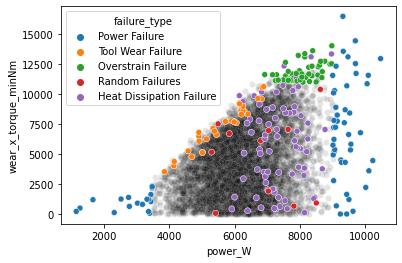

In [19]:
sns.scatterplot(x = 'power_W', y = 'wear_x_torque_minNm',
                data=df[df['failure_type']=='No Failure'],
                alpha=0.1,color='black')
sns.scatterplot(x = 'power_W', y = 'wear_x_torque_minNm',
                data=df[df['failure_type']!='No Failure'],
                hue = "failure_type")

In [20]:
lower_limit = df['power_W'][(df['failure_type'] == 'Power Failure') & (df['power_W'] < 5000)].max()
upper_limit = df['power_W'][(df['failure_type'] == 'Power Failure') & (df['power_W'] > 5000)].min()

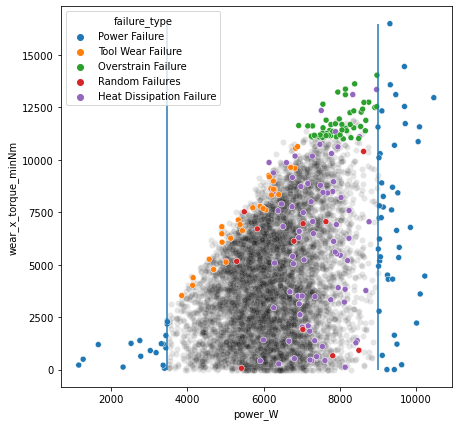

In [21]:
plt.figure(figsize=(7,7))
sns.scatterplot(x = 'power_W', y = 'wear_x_torque_minNm',
                data=df[df['failure_type']=='No Failure'],
                alpha=0.1,color='black')
sns.scatterplot(x = 'power_W', y = 'wear_x_torque_minNm',
                data=df[df['failure_type']!='No Failure'],
                hue = "failure_type")
plt.vlines(x = [lower_limit,upper_limit],ymin=df['wear_x_torque_minNm'].min(),ymax=df['wear_x_torque_minNm'].max())

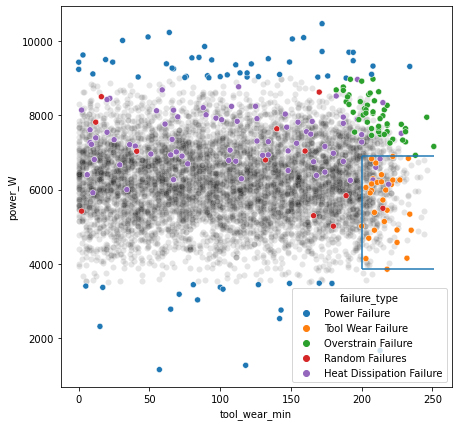

In [22]:
lower_limit = df['power_W'][(df['failure_type'] == 'Tool Wear Failure') ].max()
upper_limit = df['power_W'][(df['failure_type'] == 'Tool Wear Failure') ].min()
vert_limit = df['tool_wear_min'][(df['failure_type'] == 'Tool Wear Failure')].min()

plt.figure(figsize=(7,7))
sns.scatterplot(x = 'tool_wear_min', y = 'power_W',
                data=df[df['failure_type']=='No Failure'],
                alpha=0.1,color='black')
sns.scatterplot(x = 'tool_wear_min', y = 'power_W',
                data=df[df['failure_type']!='No Failure'],
                hue = "failure_type")
plt.hlines(y = [lower_limit,upper_limit],xmin=vert_limit,xmax=df['tool_wear_min'].max())
plt.vlines(x = vert_limit,ymin=lower_limit,ymax=upper_limit)

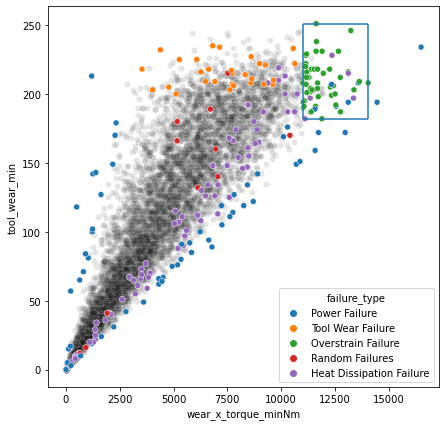

In [23]:
lower_limit_x = df['wear_x_torque_minNm'][(df['failure_type'] == 'Overstrain Failure') ].max()
upper_limit_x = df['wear_x_torque_minNm'][(df['failure_type'] == 'Overstrain Failure') ].min()
lower_limit_y = df['tool_wear_min'][(df['failure_type'] == 'Overstrain Failure')].min()
upper_limit_y = df['tool_wear_min'][(df['failure_type'] == 'Overstrain Failure')].max()

plt.figure(figsize=(7,7))
sns.scatterplot(x = 'wear_x_torque_minNm',y = 'tool_wear_min',
                data=df[df['failure_type']=='No Failure'],
                alpha=0.1,color='black')
sns.scatterplot(x = 'wear_x_torque_minNm',y = 'tool_wear_min',
                data=df[df['failure_type']!='No Failure'],
                hue = "failure_type")
plt.hlines(y = [lower_limit_y,upper_limit_y],xmin=lower_limit_x,xmax=upper_limit_x)
plt.vlines(x = [lower_limit_x,upper_limit_x],ymin=lower_limit_y,ymax=upper_limit_y)

In [24]:
df.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,diff_temperature_air_process,power_W,wear_x_torque_minNm
0,M,298.1,308.6,1551,42.8,0,No Failure,10.5,6951.6,0.0
1,L,298.2,308.7,1408,46.3,3,No Failure,10.5,6826.7,138.9
2,L,298.2,308.7,1408,40.0,9,No Failure,10.5,5897.8,360.0
3,M,298.1,308.6,1425,41.9,11,No Failure,10.5,6252.6,460.9
4,L,298.1,308.6,1558,42.4,14,No Failure,10.5,6917.7,593.6


Por fim, nesta análise exploratória, vamos analisar os dados usando também as variáveis categóricas. Vemos que esta informação está contida na coluna `type` onde as letras L/M/H são abreviações para _Low_,_Medium_ e _High_, respectivamente.

###Porcentagem de peças por tipo###
L    60.0
M    30.0
H    10.0
Name: type, dtype: float64


Text(0, 0.5, 'Tipo')

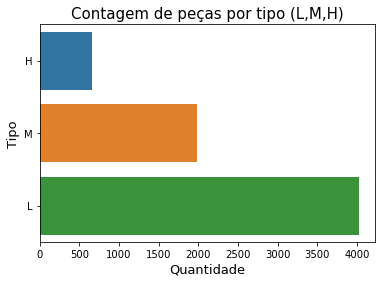

In [25]:
#Qual a porcentagem de peças de cada tipo?
print('###Porcentagem de peças por tipo###')
print(round(df['type'].value_counts(normalize=True),2)*100)

sns.countplot(data=df, y = 'type',order=['H','M','L'])
plt.title('Contagem de peças por tipo (L,M,H)',fontsize=15)
plt.xlabel('Quantidade',fontsize=13)
plt.ylabel('Tipo',fontsize=13)

De acordo com o dicionário, a falha de `Overstrain Failure` é a que tem maior relação com o tipo da peça. Por isso, vamos fazer um gráfico de espalhamento para ver se existe, de fato, esta relação. 

<AxesSubplot:xlabel='tool_wear_min', ylabel='wear_x_torque_minNm'>

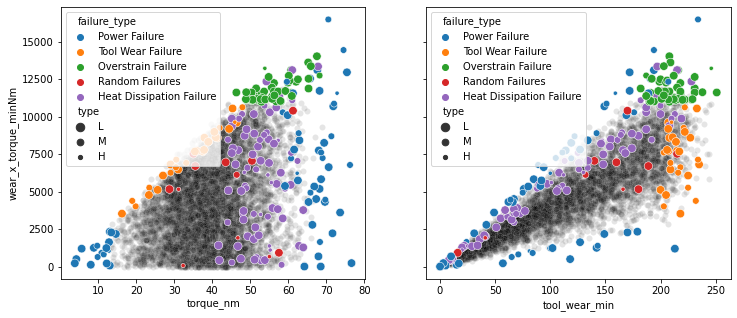

In [26]:
fig, ax = plt.subplots(1,2,figsize=(12,5),sharey = True)
sns.scatterplot(x = 'torque_nm',y = 'wear_x_torque_minNm',
                data=df[df['failure_type']=='No Failure'],
                alpha=0.1,color='black',ax=ax[0])
sns.scatterplot(x = 'torque_nm',y = 'wear_x_torque_minNm',
                data=df[df['failure_type']!='No Failure'],
                hue = "failure_type",size = 'type',ax=ax[0])
sns.scatterplot(x = 'tool_wear_min',y = 'wear_x_torque_minNm',
                data=df[df['failure_type']=='No Failure'],
                alpha=0.1,color='black',ax=ax[1])
sns.scatterplot(x = 'tool_wear_min',y = 'wear_x_torque_minNm',
                data=df[df['failure_type']!='No Failure'],
                hue = "failure_type",size = 'type',ax=ax[1])


Não fica visualmente perceptível a relação dos erros em função do tipo da peça. Provavelmente isso ocorra devido ao desbalanço das classes de tipos, sendo que apenas 10% seja do tipo H. 

# Resumo

Nesta análise exploratória dos dados demos uma olhada na distribuição das colunas por meio de boxplots (variáveis numéricas) e de contagem (variáveis categóricas). Fizemos vários gráficos de dispersão entre diferentes variáveis para tentar encontrar uma relação entre os tipos de falhas e características fornecidas pelos dados. Os achados encontram-se mostrados nos gráficos acima. 

A partir do dataframe original, foram excluídas duas colunas (`uid` e `product_id`), foram adicionadas três novas colunas (`diff_temperature_air_process`, `power_W` e `wear_x_torque_minNm`). Como estes dados são de treino, as mesmas alterações deverão ser realizadas nos dados de teste. Logo, abaixo deixo a função que fará toda essa alteração automaticamente. 


In [27]:
def ajuste_dataframe(filename_in,filename_out):
    df = pd.read_csv(filename_in)
    df = df.drop(columns=['udi','product_id'])
    df['diff_temperature_air_process'] = df['process_temperature_k'] - df['air_temperature_k']
    df['power_W'] = round(2*np.pi*df['rotational_speed_rpm']*df['torque_nm']/60,1)
    df['wear_x_torque_minNm'] = df['torque_nm']*df['tool_wear_min']
    return df.to_csv(filename_out,index=False)

In [28]:
ajuste_dataframe('desafio_manutencao_preditiva_treino.csv','desafio_manutencao_preditiva_treino_final.csv')
ajuste_dataframe('desafio_manutencao_preditiva_teste.csv','desafio_manutencao_preditiva_teste_final.csv')

In [29]:
treino = pd.read_csv('desafio_manutencao_preditiva_treino_final.csv')
display(treino.head())
teste = pd.read_csv('desafio_manutencao_preditiva_teste_final.csv')
display(teste.head())

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,diff_temperature_air_process,power_W,wear_x_torque_minNm
0,M,298.1,308.6,1551,42.8,0,No Failure,10.5,6951.6,0.0
1,L,298.2,308.7,1408,46.3,3,No Failure,10.5,6826.7,138.9
2,L,298.2,308.7,1408,40.0,9,No Failure,10.5,5897.8,360.0
3,M,298.1,308.6,1425,41.9,11,No Failure,10.5,6252.6,460.9
4,L,298.1,308.6,1558,42.4,14,No Failure,10.5,6917.7,593.6


,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,diff_temperature_air_process,power_W,wear_x_torque_minNm
0,L,297.5,308.6,1793,26.7,70,11.1,5013.3,1869.0
1,L,300.7,310.5,1536,47.4,192,9.8,7624.3,9100.8
2,L,297.2,308.4,1460,42.1,41,11.2,6436.7,1726.1
3,L,299.4,309.1,1670,35.9,68,9.7,6278.3,2441.2
4,L,304.1,313.1,1550,30.9,9,9.0,5015.6,278.1


# Extras

A seguir estão rotinas que podem ter sido usadas temporariamente em algum momento da análise exploratória.

In [30]:
#columns = list(df.drop(columns=['failure_type','type']).columns)
#columns.append('failure_type')
#
#df_aux = df#
#
#fig,axes = plt.subplots(len(columns)-1,len(columns)-1,figsize=(25,25))
#
#for column_name_1 in columns[:-1]:
#    for column_name_2 in columns[:-1]:
#        sns.scatterplot(x = column_name_2, y = column_name_1,
#                data=df_aux[df_aux['failure_type']=='No Failure'],
#                alpha=0.1,color='black',
#               ax = axes[columns.index(column_name_1),columns.index(column_name_2)])
#        sns.scatterplot(x = column_name_2,y = column_name_1,
#                data=df_aux[df_aux['failure_type']!='No Failure'],
#                hue = "failure_type",
#               ax = axes[columns.index(column_name_1),columns.index(column_name_2)])